In [1]:
include("./main_parser.jl")

draw_hg (generic function with 1 method)

In [2]:
using PyCall, BSON, DecisionTree, Random, CSV

In [3]:
BSON.@load "models/model_rf.bson" rf uniques

spacy = pyimport("spacy")

nlp = spacy.load("en_core_web_lg")

PyObject <spacy.lang.en.English object at 0x7efd982c7710>

In [139]:
data = DataFrame(CSV.File("data/articles_modified_short.csv"));

In [140]:
df = convert_df(data[:, 1], uniques, rf);

In [141]:
data = innerjoin(df, data, on =:Article);

In [142]:
nrow(data)

509

In [143]:
nrow(filter(:relation => ==(0), data))

234

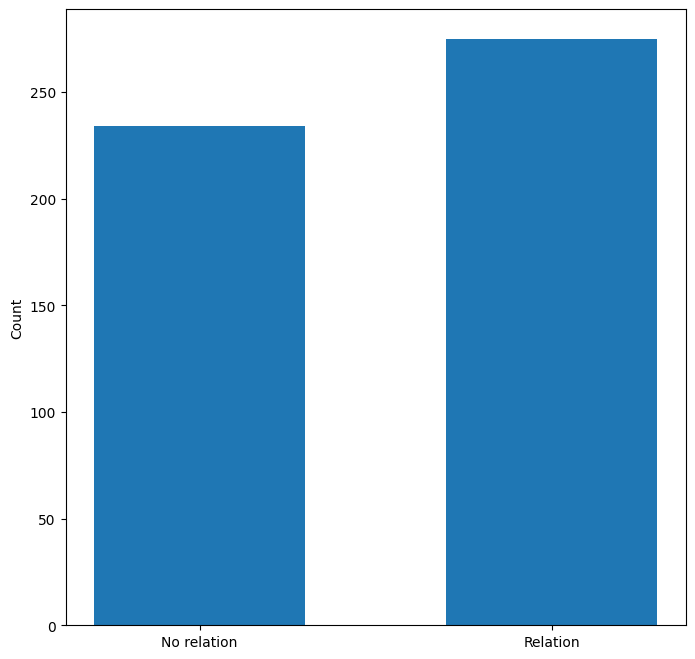

In [144]:
using PyPlot
fig, ax = subplots(figsize=(8,8))
PyPlot.bar([0, 1], [nrow(filter(:relation => ==(0), data)), 
                        nrow(filter(:relation => ==(1), data))],
            width=0.6)
PyPlot.xticks([0,1 ], ["No relation", "Relation"])
PyPlot.ylabel("Count")
PyPlot.savefig("hist.png");

In [145]:
ENV["LINES"], ENV["COLUMNS"] = 80, 1000

(80, 1000)

In [146]:
atoms = data[:, :Atoms];

In [147]:
atoms_dict = Dict()
for article in atoms
    for atom in article
        if !(atom in keys(atoms_dict))
            atoms_dict[atom] = 1
        else
            atoms_dict[atom] += 1
        end
    end
end

In [148]:
atoms_dict

Dict{Any, Any} with 6 entries:
  "B" => 193
  "J" => 29
  "M" => 583
  "C" => 2326
  "P" => 530
  "T" => 492

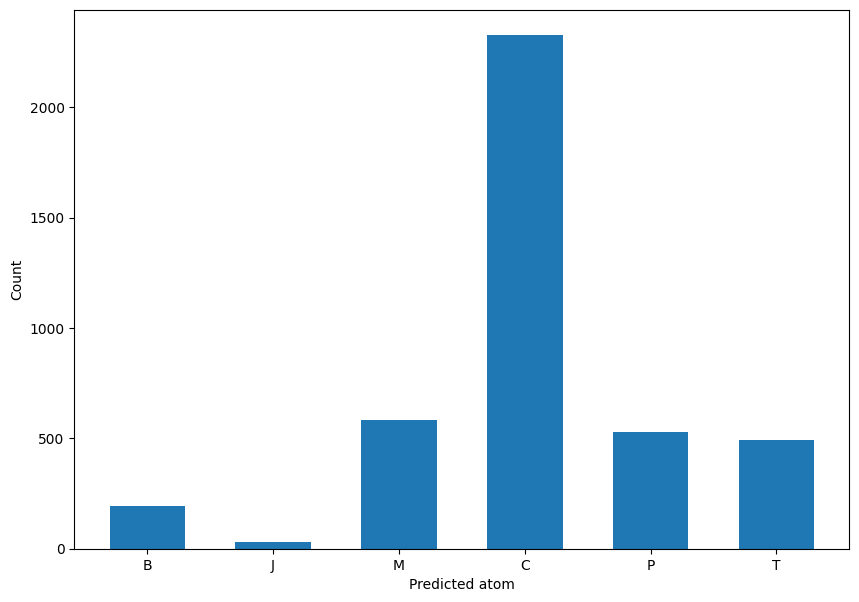

In [149]:
fig, ax = subplots(figsize=(10,7))
PyPlot.bar([1,2,3,4,5,6], [value for value in values(atoms_dict)],
            width=0.6)
PyPlot.ylabel("Count")
PyPlot.xticks([1,2,3,4,5,6], [key for key in keys(atoms_dict)])
PyPlot.xlabel("Predicted atom")
PyPlot.savefig("atoms.png");

In [176]:
# predicates = ["dips", "rebounds", "firms"]
predicates = ["dips", "rebounds", "firms", "posts", 
              "edges", "hikes", "ticks", "struggles", "ends"]
currencies = ["pound", "dollar", "sterling", "euro", "dollar", "lira", "aussie",
              "gbpusd", "gbp", "usdcad", "sterlin", "myanmar", "yuan", "zloty", "forint",
              "yen", "usd/cad", "ruble", "lebanon's", "rouble", "swiss", "rupee",
              "eurusd"];

In [151]:
function get_hg_tokens(text, atoms, currencies=[], predicates=[])
    doc = nlp(text)
#     hg, tokens = nothing
    try
        for (i, token) in enumerate(doc)
            if lowercase(token.text) in currencies
                atoms[i] = "C"
            end
            if lowercase(token.text) in predicates
                atoms[i] = "P"
            end
        end
        beta(patterns, doc, atoms)
    catch e
        return nothing
    end
#     return hg, tokens
end

get_hg_tokens (generic function with 3 methods)

In [152]:
function model_1(currencies_list, article)
    if any(y -> occursin(y, lowercase(article)), currencies_list)
        return 1
    else
        return 0
    end
end     

model_1 (generic function with 1 method)

In [153]:
function model_2(currencies_list, article)
    output = 0
    currencies_indexes = []
    doc = nlp(article)
    for (i, token) in enumerate(doc)
        if lowercase(token.text) in currencies_list
            append!(currencies_indexes, i)
        end
    end
    for i in currencies_indexes
        if length(doc) > i
            if doc[i+1].pos_ == "VERB"
                output = 1
            end
        end
    end
    return output
end   

model_2 (generic function with 1 method)

In [154]:
function check_curr(token, currencies_list)
    curr_check = lowercase(token.text) in currencies_list
    return curr_check
end 

check_curr (generic function with 1 method)

In [155]:
x = ["to"]
any(x -> lowercase(x) in ["to", "for"], x)

true

In [156]:
function check_connector(doc, atoms)
#     last_tokens = input[1]
#     t_index = findall(x->x == "T", last_tokens)
#     if length(t_index) == 0
#         return true
#     else
#         t_texts = []
#         for token in input[2][t_index]
#             try
#                 append!(t_texts, [token.text])
#             catch e
#             end
#         end
#         if any(y-> lowercase(y) in ["to", "for"], t_texts)
#             return false
#         else
#             return true
#         end
#     end
    t_index = findall(x->x == "T", atoms)
    texts = [token.text for token in doc]
    if length(t_index) == 0
        return true
    else
        t_texts = texts[t_index]
        if all(y -> lowercase(y) in ["to", "for"], t_texts)
            return false
        else
            return true
        end
    end
end

check_connector (generic function with 2 methods)

In [157]:
function model_3(article, atoms, currencies_list, predicates)
    output = 0
    doc = nlp(article)
    out = get_hg_tokens(article, atoms, currencies_list, predicates)
#     if (!(out == nothing) & (any(y -> occursin(y, lowercase(article)), currencies_list)))
    if !(out == nothing)
        conn = check_connector(doc, atoms)
        indexes = findall(x -> x in ['S', 'R'], out[3])
        for index in indexes
            relations = findall(x -> x==1, out[1][:, index])
            if (length(relations) > 3) & (conn) 
                for word in relations
                    curr = check_curr(doc[word], currencies_list)
                    if curr
#                         conn = check_connector(out[2][index-1])
#                         if conn
#                             return 1
#                         else
#                             return 0
#                         end
                        return 1
                    end
                end
            end
        end
    end
    return 0
end

model_3 (generic function with 1 method)

In [158]:
insertcols!(data, 4, :Model1 => 0, :Model2 => 0, :Model3 => 0);

In [177]:
for row in eachrow(data)
    row.Model1 = model_1(currencies, row.Article)
    row.Model2 = model_2(currencies, row.Article)
    row.Model3 = model_3(row.Article, row.Atoms, currencies, predicates)
end

In [160]:
function recall(target, model)
    p1 = filter(row -> (row[model] == 1) & (row[target] == 1), data)
    p2 = filter(row -> row[target] == 1, data)
    return nrow(p1)/nrow(p2)
end

recall (generic function with 1 method)

In [161]:
function precision(target, model)
    p1 = filter(row -> (row[model] == 1) & (row[target] == 1), data)
    p2 = filter(row -> (row[model] == 1) & (row[target] == 0), data)
    return nrow(p1)/(nrow(p2) + nrow(p1))
end

precision (generic function with 1 method)

In [162]:
function f1(precision, recall)
    return 2*precision*recall/(precision+recall)
end

f1 (generic function with 1 method)

In [178]:
prec = precision("relation", "Model1")

0.7902298850574713

In [179]:
rec = recall("relation", "Model1")

1.0

In [180]:
f1(prec, rec)

0.8828250401284109

In [166]:
prec = precision("relation", "Model2")

0.7956204379562044

In [167]:
rec = recall("relation", "Model2")

0.39636363636363636

In [168]:
f1(prec, rec)

0.529126213592233

In [181]:
prec = precision("relation", "Model3")

0.8646864686468647

In [182]:
rec = recall("relation", "Model3")

0.9527272727272728

In [183]:
f1(prec, rec)

0.9065743944636679

In [185]:
false_negative = filter(row -> (row["Model1"] == 1) & (row["Model3"] == 0), data)

,Article,Atoms,relation,Model1,Model2,Model3
,String,Array…,Int64,Int64,Int64,Int64
1,Dollar Edges Lower,"[""C"", ""P"", ""M""]",0,1,0,0
2,EURUSD marginally lower but traders lean against the 100 hour MA on the first looks,"[""C"", ""M"", ""C"", ""J"", ""C"", ""P"", ""T"", ""M"", ""M"", ""C"", ""C"", ""B"", ""M"", ""M"", ""C""]",0,1,0,0
3,Dollar Finds Support,"[""C"", ""P"", ""C""]",0,1,1,0
4,Cuban peso in free fall against the dollar,"[""M"", ""C"", ""T"", ""M"", ""C"", ""T"", ""M"", ""C""]",0,1,0,0
5,Dollar Edges Higher,"[""C"", ""P"", ""M""]",0,1,0,0
6,China could take further measures to rein in yuan- former regulator,"[""C"", ""M"", ""P"", ""M"", ""C"", ""M"", ""P"", ""M"", ""C"", ""M"", ""C""]",0,1,0,0
7,Dollar Largely Flat,"[""C"", ""M"", ""M""]",0,1,0,0
8,Dollar dips with US Treasury yields but still up for week,"[""C"", ""P"", ""T"", ""C"", ""C"", ""C"", ""J"", ""M"", ""T"", ""M"", ""C""]",1,1,0,0
9,Dollar Up As the Fed Signals An Earlier Interest Rate Hike,"[""C"", ""M"", ""M"", ""M"", ""C"", ""C"", ""C"", ""M"", ""C"", ""C"", ""C""]",1,1,0,0


In [173]:
hg, edges, atoms = get_hg_tokens(false_negative[1, 1], false_negative[1, 2], currencies, predicates);

LoadError: MethodError: no method matching iterate(::Nothing)
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:664
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Int64[39m) at range.jl:664
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{var"#s79", var"#s78"} where {var"#s79", var"#s78"<:Dict}, Base.ValueIterator{var"#s77"} where var"#s77"<:Dict} at dict.jl:693
[0m  ...

In [137]:
atoms

7-element Vector{Any}:
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 'B': ASCII/Unicode U+0042 (category Lu: Letter, uppercase)
 'S': ASCII/Unicode U+0053 (category Lu: Letter, uppercase)
 'R': ASCII/Unicode U+0052 (category Lu: Letter, uppercase)
 'P': ASCII/Unicode U+0050 (category Lu: Letter, uppercase)
 'P': ASCII/Unicode U+0050 (category Lu: Letter, uppercase)

In [138]:
edges

Dict{Int64, Tuple{Vector{String}, Vector{PyObject}}} with 8 entries:
  0 => (["M", "P", "B", "C", "J", "M", "C", "P", "T", "C", "B", "C"], [PyObject Asymmetric, PyObject risks, PyObject around, PyObject inflation, PyObject and, PyObject higher, PyObject rates, PyObject emerge, PyObject in, PyObject USD, PyObject /, PyObject CAD])
  4 => (["M", "P", "B", "C", "P", "S"], [PyObject Asymmetric, PyObject risks, PyObject [around, inflation, and], PyObject [higher, rates], PyObject emerge, PyObject [in, [USD, /, CAD]]])
  5 => (["M", "P", "B", "R"], [PyObject Asymmetric, PyObject risks, PyObject [around, inflation, and], PyObject [[higher, rates], emerge, [in, [USD, /, CAD]]]])
  6 => (["P", "B", "R"], [PyObject [Asymmetric, risks], PyObject [around, inflation, and], PyObject [[higher, rates], emerge, [in, [USD, /, CAD]]]])
  2 => (["M", "P", "B", "C", "J", "C", "P", "T", "C"], [PyObject Asymmetric, PyObject risks, PyObject around, PyObject inflation, PyObject and, PyObject [higher, rates], P

In [335]:
edges[4]

(["S"], PyObject[PyObject [[[Lira, Slumps], to], [New, Low]]])

In [339]:
check_connector(edges[2])

[2]PyObject to
false

false